## 0. Mount Drive


In [ ]:
# prompt: load drive from google colab, force remount true

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


## 1. Load Dataset (Train + Test)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import os
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

base_dir ='/content/drive/MyDrive/'
root_directory = base_dir+'traffic_symbol_classification'

class GermanTrafficSignDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Load images and labels
        for label_dir in os.listdir(self.root_dir):
            if label_dir == '.DS_Store':  # Skip .DS_Store files
                continue
            try:
              class_id = int(label_dir)  # Convert folder name to integer label
            except ValueError:
              continue
            class_dir = os.path.join(self.root_dir, label_dir)
            for image_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, image_name))
                self.labels.append(class_id)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')  # Ensure image is RGB
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to be consistent with model input
    transforms.ToTensor(),        # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Instantiate the dataset
dataset = GermanTrafficSignDataset(root_dir=root_directory, transform=transform)

# Split dataset into training and evaluation
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## 2. Training & Evaluation Function

In [ ]:
def training_evaluation(model,weight_key,n_epochs):

  # Move the model to GPU if available
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(device)
  model = model.to(device)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Training loop
  num_epochs = n_epochs
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

      # Evaluation per epoch
      model.eval()
      total = 0
      correct = 0
      with torch.no_grad():
          for inputs, labels in tqdm(test_loader, desc=f"Evaluating Epoch {epoch+1}"):
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
      accuracy = 100 * correct / total
      print(f"Accuracy after epoch {epoch+1}: {accuracy:.2f}%")

  torch.save(model.state_dict(), base_dir+weight_key+'.pth')
  print("Training completed and model saved.")


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

def training_evaluation_2(model, weight_key, n_epochs):
    # Move the model to GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=0.001)
    # scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

    # Early stopping variables
    best_accuracy = 0
    early_stop_count = 0
    early_stop_limit = 5

    # Training loop
    num_epochs = n_epochs
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

        # Evaluation per epoch
        model.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f"Evaluating Epoch {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Accuracy after epoch {epoch+1}: {accuracy:.2f}%")

        # Learning rate scheduler step
        scheduler.step(accuracy)

        # Early stopping logic
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            early_stop_count = 0
            # Save the best model
            torch.save(model.state_dict(), base_dir + weight_key + '.pth')
        else:
            early_stop_count += 1
            if early_stop_count >= early_stop_limit:
                print("Stopping early due to no improvement")
                break

    print("Training completed and best model saved.")

## 3. Testing & Results Visualization Function

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

def testing(model, weight_key):
    # Assuming base_dir is defined elsewhere in your code and points to the directory containing your model weights

    # Load your trained model
    model.load_state_dict(torch.load(base_dir + weight_key + '.pth'))
    model.eval()  # Set the model to evaluation mode

    # Move the model to GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize lists to track all predictions and true labels
    all_preds = []
    all_labels = []

    # Testing loop with tqdm for progress bar
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=True):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

    # Calculate and print precision, recall, and F1-score
    print(classification_report(all_labels, all_preds, digits=3))

    # Assuming 'all_preds' and 'all_labels' are your lists of predictions and true labels
    cm = confusion_matrix(all_labels, all_preds)

    # Define class names
    class_names = [f'Class {i}' for i in range(43)]  # Adjust the range based on your classes

    # Plot and show confusion matrix
    plot_confusion_matrix(cm, weight_key, class_names=class_names)

    plt.show()

def plot_confusion_matrix(cm, weight_key, class_names, normalize=False):
    # Dynamically adjust figure size based on the number of classes
    fig_size = max(12, len(class_names) * 0.5)
    plt.figure(figsize=(fig_size, fig_size))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix for ' + weight_key
    else:
        title = 'Confusion Matrix, without normalization for ' + weight_key
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.

    # Only annotate significant cells to avoid clutter
    significant_thresh = np.mean(cm)  # Define what you consider 'significant'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] > significant_thresh:  # Only annotate significant values
            if normalize:
                plt.text(j, i, format(cm[i, j], '.2f'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()






## 4. Training with Pretrained RESNET50

In [ ]:
model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 43)  # Assuming 43 classes
weight_key = 'resnet50'
# Ensure that the model architecture matches the one used during training
training_evaluation(model,weight_key,n_epochs=25)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 16/16 [00:04<00:00,  3.81it/s]


Epoch 1, Loss: 2.7520810961723328


Evaluating Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


Accuracy after epoch 1: 37.86%


Epoch 2: 100%|██████████| 16/16 [00:04<00:00,  3.92it/s]


Epoch 2, Loss: 1.5596363320946693


Evaluating Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Accuracy after epoch 2: 55.56%


Epoch 3: 100%|██████████| 16/16 [00:03<00:00,  4.08it/s]


Epoch 3, Loss: 1.1681861504912376


Evaluating Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Accuracy after epoch 3: 66.67%


Epoch 4: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]


Epoch 4, Loss: 0.937854066491127


Evaluating Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


Accuracy after epoch 4: 74.07%


Epoch 5: 100%|██████████| 16/16 [00:03<00:00,  4.04it/s]


Epoch 5, Loss: 0.9102335162460804


Evaluating Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Accuracy after epoch 5: 58.85%


Epoch 6: 100%|██████████| 16/16 [00:04<00:00,  3.98it/s]


Epoch 6, Loss: 0.8269244953989983


Evaluating Epoch 6: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Accuracy after epoch 6: 80.25%


Epoch 7: 100%|██████████| 16/16 [00:04<00:00,  3.77it/s]


Epoch 7, Loss: 0.5242721103131771


Evaluating Epoch 7: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Accuracy after epoch 7: 75.72%


Epoch 8: 100%|██████████| 16/16 [00:03<00:00,  4.05it/s]


Epoch 8, Loss: 0.4813022166490555


Evaluating Epoch 8: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Accuracy after epoch 8: 76.13%


Epoch 9: 100%|██████████| 16/16 [00:03<00:00,  4.03it/s]


Epoch 9, Loss: 0.6862261444330215


Evaluating Epoch 9: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


Accuracy after epoch 9: 78.60%


Epoch 10: 100%|██████████| 16/16 [00:04<00:00,  3.94it/s]


Epoch 10, Loss: 0.6876298487186432


Evaluating Epoch 10: 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Accuracy after epoch 10: 83.54%


Epoch 11: 100%|██████████| 16/16 [00:04<00:00,  3.95it/s]


Epoch 11, Loss: 0.39520850218832493


Evaluating Epoch 11: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


Accuracy after epoch 11: 87.24%


Epoch 12: 100%|██████████| 16/16 [00:04<00:00,  3.81it/s]


Epoch 12, Loss: 0.2535022795200348


Evaluating Epoch 12: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


Accuracy after epoch 12: 92.59%


Epoch 13: 100%|██████████| 16/16 [00:03<00:00,  4.01it/s]


Epoch 13, Loss: 0.2481436573434621


Evaluating Epoch 13: 100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


Accuracy after epoch 13: 88.48%


Epoch 14: 100%|██████████| 16/16 [00:04<00:00,  3.94it/s]


Epoch 14, Loss: 0.2200547754764557


Evaluating Epoch 14: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Accuracy after epoch 14: 91.77%


Epoch 15: 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]


Epoch 15, Loss: 0.49701341101899743


Evaluating Epoch 15: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Accuracy after epoch 15: 80.66%


Epoch 16: 100%|██████████| 16/16 [00:03<00:00,  4.05it/s]


Epoch 16, Loss: 0.40804907493293285


Evaluating Epoch 16: 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


Accuracy after epoch 16: 87.24%


Epoch 17: 100%|██████████| 16/16 [00:03<00:00,  4.04it/s]


Epoch 17, Loss: 0.2445793030783534


Evaluating Epoch 17: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


Accuracy after epoch 17: 89.71%


Epoch 18: 100%|██████████| 16/16 [00:04<00:00,  3.79it/s]


Epoch 18, Loss: 0.2735489693004638


Evaluating Epoch 18: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Accuracy after epoch 18: 87.65%


Epoch 19: 100%|██████████| 16/16 [00:03<00:00,  4.02it/s]


Epoch 19, Loss: 0.48933109175413847


Evaluating Epoch 19: 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Accuracy after epoch 19: 80.25%


Epoch 20: 100%|██████████| 16/16 [00:04<00:00,  3.88it/s]


Epoch 20, Loss: 0.284725540317595


Evaluating Epoch 20: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


Accuracy after epoch 20: 88.48%


Epoch 21: 100%|██████████| 16/16 [00:04<00:00,  3.93it/s]


Epoch 21, Loss: 0.20708972634747624


Evaluating Epoch 21: 100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Accuracy after epoch 21: 90.12%


Epoch 22: 100%|██████████| 16/16 [00:03<00:00,  4.09it/s]


Epoch 22, Loss: 0.2618793761357665


Evaluating Epoch 22: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Accuracy after epoch 22: 77.78%


Epoch 23: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]


Epoch 23, Loss: 0.5431780298240483


Evaluating Epoch 23: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Accuracy after epoch 23: 83.95%


Epoch 24: 100%|██████████| 16/16 [00:03<00:00,  4.00it/s]


Epoch 24, Loss: 0.3020584797486663


Evaluating Epoch 24: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Accuracy after epoch 24: 89.71%


Epoch 25: 100%|██████████| 16/16 [00:04<00:00,  3.91it/s]


Epoch 25, Loss: 0.19232871499843895


Evaluating Epoch 25: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Accuracy after epoch 25: 90.53%
Training completed and model saved.


## 5. Testing with Resnet50

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Testing: 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local

Accuracy of the model on the test images: 97.12%
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000        12
           2      0.917     1.000     0.957        11
           3      1.000     1.000     1.000         7
           4      1.000     0.947     0.973        19
           5      1.000     0.933     0.966        15
           6      1.000     1.000     1.000         3
           7      1.000     0.889     0.941         9
           8      0.867     1.000     0.929        13
           9      0.889     1.000     0.941         8
          10      1.000     1.000     1.000        22
          11      0.889     1.000     0.941         8
          12      1.000     1.000     1.000        11
          13      1.000     1.000     1.000        18
          14      1.000     1.000     1.000        10
          15      1.000     1.000     1.000         2
          16      0.000     0.00

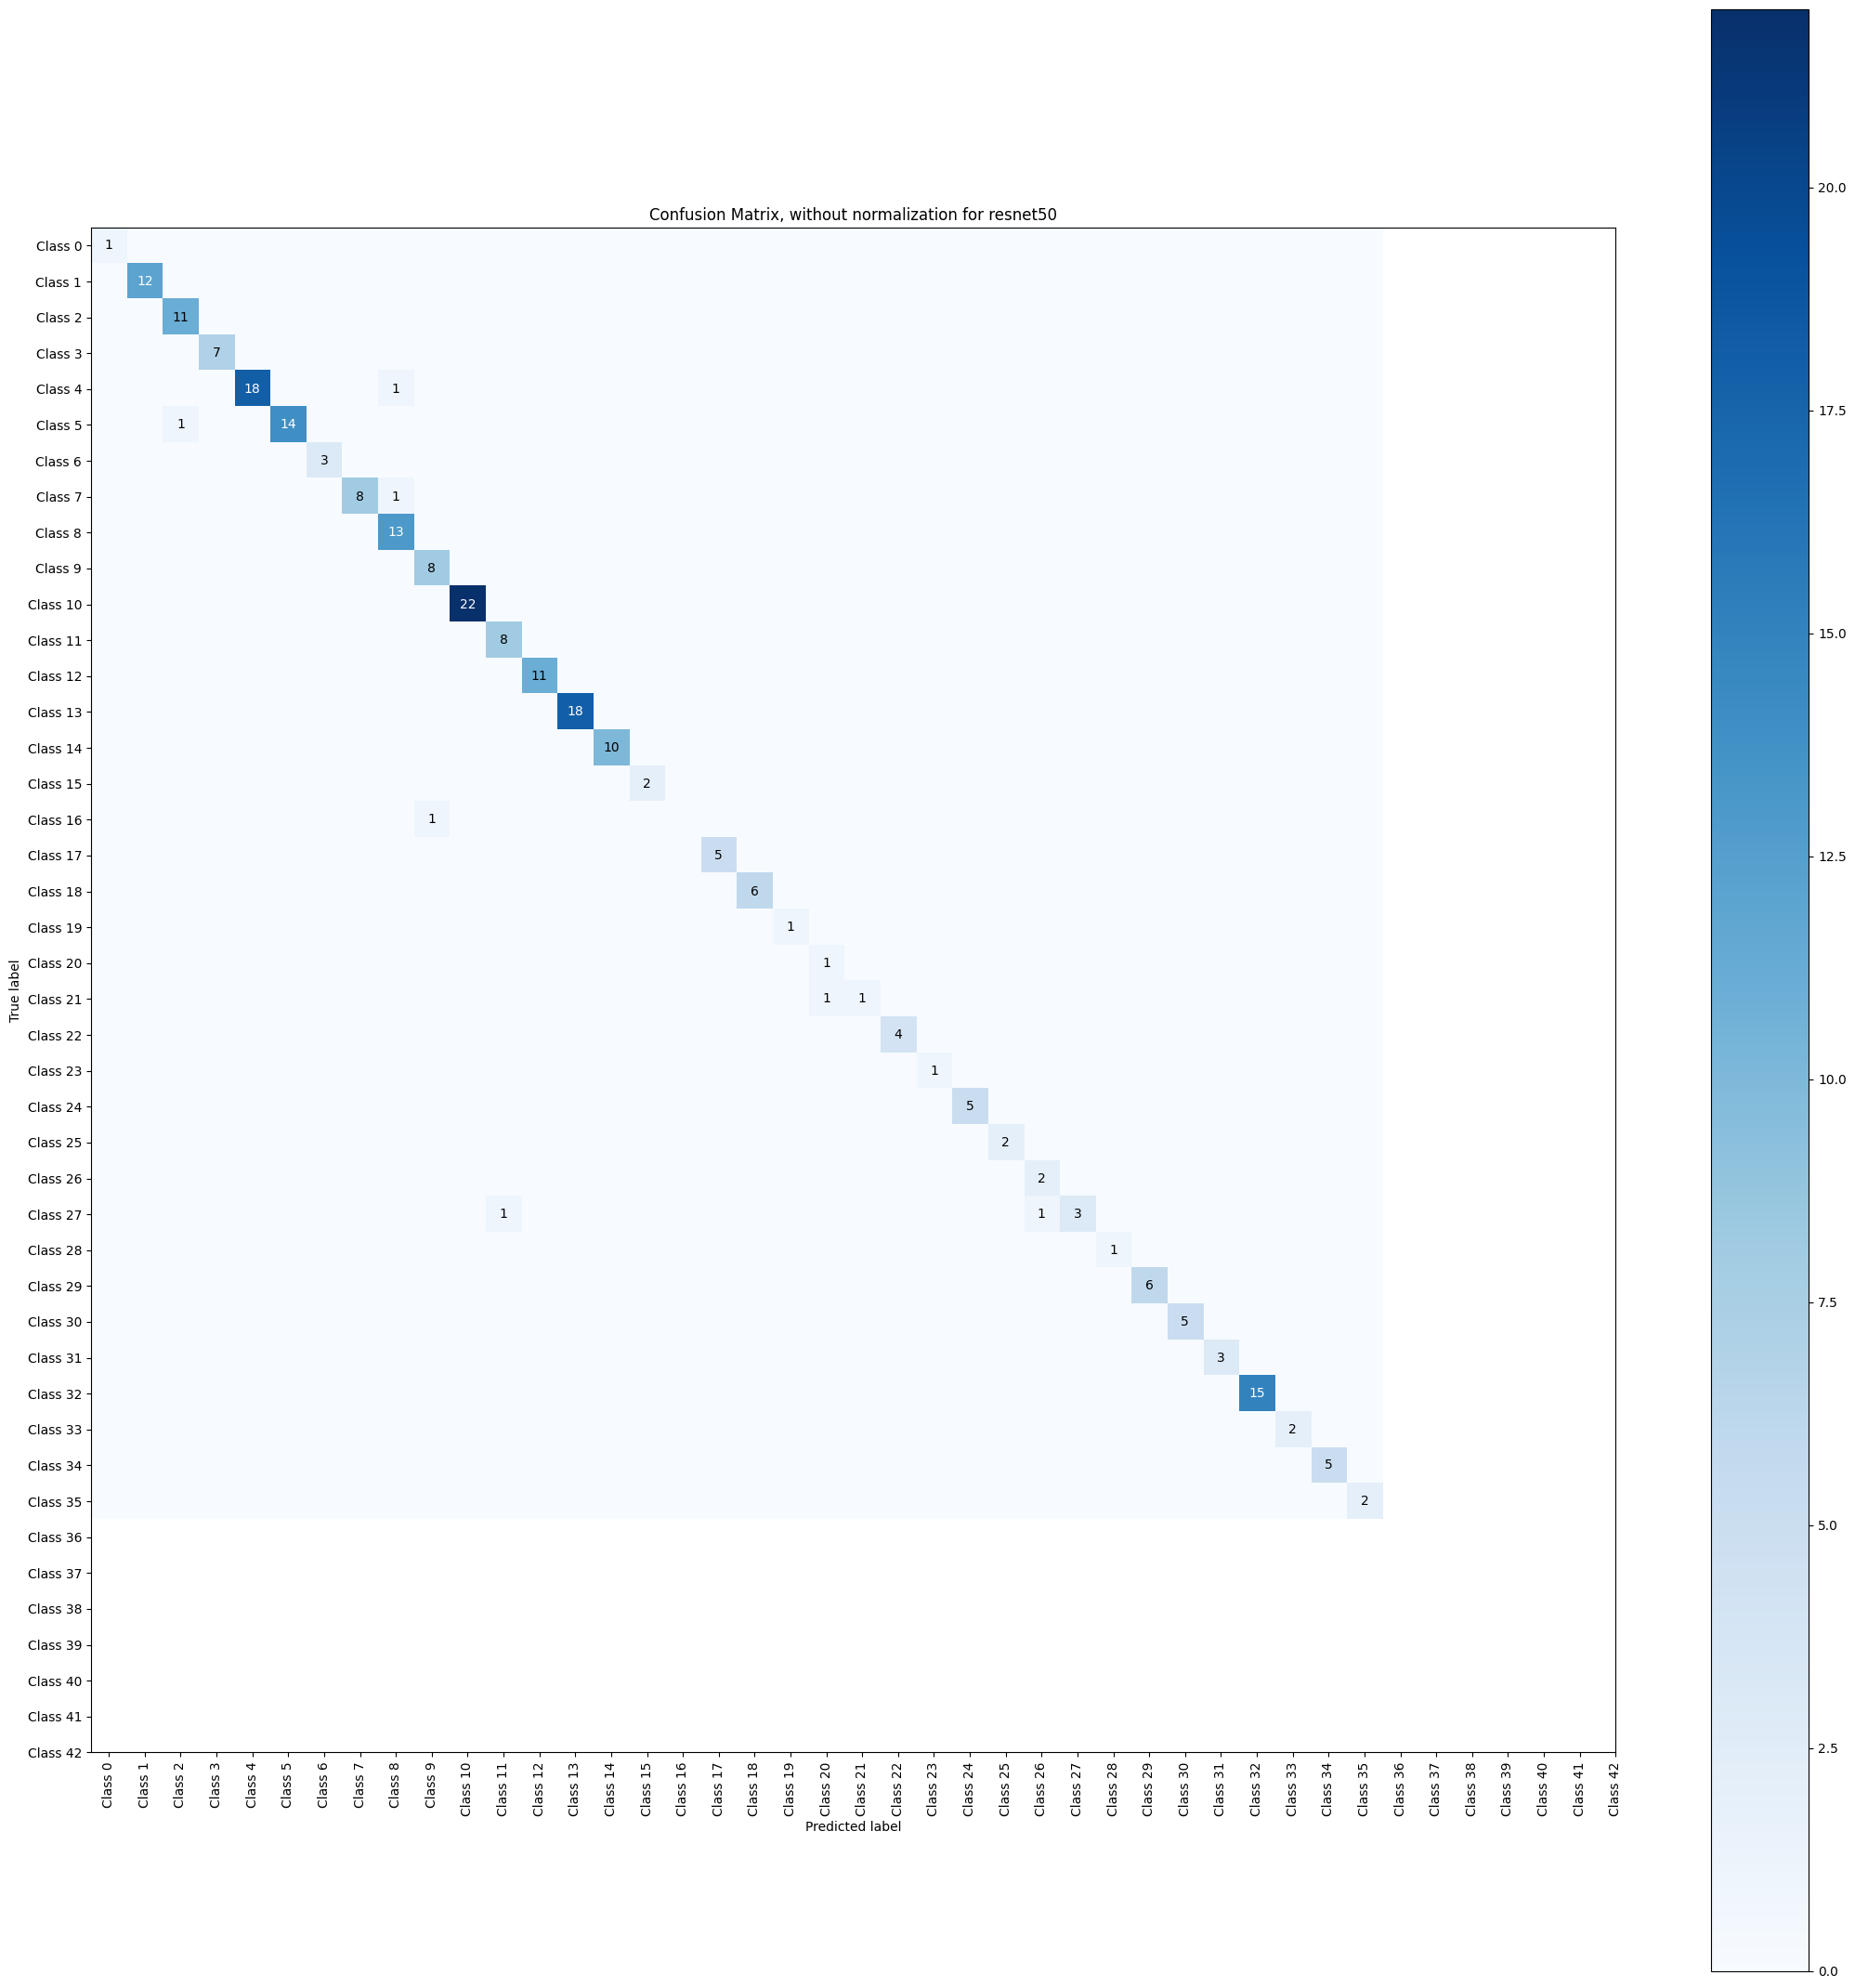

In [ ]:
model = models.resnet50(pretrained=True)
weight_key = 'resnet50'
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 43)  # Assuming 43 classes
testing(model,weight_key)

### 5.1 Prediction

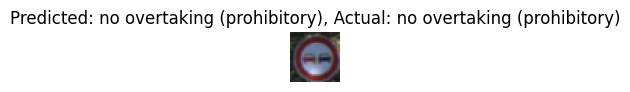

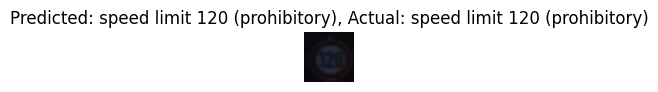

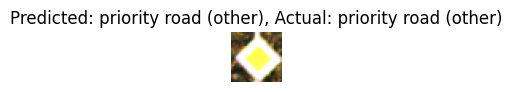

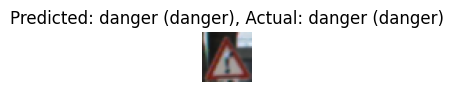

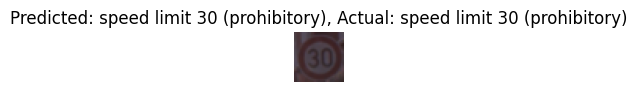

In [ ]:
# Import necessary modules
import matplotlib.pyplot as plt
from torch.utils.data import Subset

# Function to automatically pick a subset of test images and predict labels
def predict_and_display_test_images(model, weight_key, num_images=5):
    # Load your trained model
    model.load_state_dict(torch.load(base_dir + weight_key + '.pth'))
    model.eval()  # Set the model to evaluation mode

    # Move the model to GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    class_names = {
        0: 'speed limit 20 (prohibitory)',
        1: 'speed limit 30 (prohibitory)',
        2: 'speed limit 50 (prohibitory)',
        3: 'speed limit 60 (prohibitory)',
        4: 'speed limit 70 (prohibitory)',
        5: 'speed limit 80 (prohibitory)',
        6: 'restriction ends 80 (other)',
        7: 'speed limit 100 (prohibitory)',
        8: 'speed limit 120 (prohibitory)',
        9: 'no overtaking (prohibitory)',
        10: 'no overtaking (trucks) (prohibitory)',
        11: 'priority at next intersection (danger)',
        12: 'priority road (other)',
        13: 'give way (other)',
        14: 'stop (other)',
        15: 'no traffic both ways (prohibitory)',
        16: 'no trucks (prohibitory)',
        17: 'no entry (other)',
        18: 'danger (danger)',
        19: 'bend left (danger)',
        20: 'bend right (danger)',
        21: 'bend (danger)',
        22: 'uneven road (danger)',
        23: 'slippery road (danger)',
        24: 'road narrows (danger)',
        25: 'construction (danger)',
        26: 'traffic signal (danger)',
        27: 'pedestrian crossing (danger)',
        28: 'school crossing (danger)',
        29: 'cycles crossing (danger)',
        30: 'snow (danger)',
        31: 'animals (danger)',
        32: 'restriction ends (other)',
        33: 'go right (mandatory)',
        34: 'go left (mandatory)',
        35: 'go straight (mandatory)',
        36: 'go right or straight (mandatory)',
        37: 'go left or straight (mandatory)',
        38: 'keep right (mandatory)',
        39: 'keep left (mandatory)',
        40: 'roundabout (mandatory)',
        41: 'restriction ends (overtaking) (other)',
        42: 'restriction ends (overtaking (trucks)) (other)'
    }

    # Randomly select a subset of test images
    indices = np.random.choice(range(len(test_dataset)), num_images, replace=False)
    subset = Subset(test_dataset, indices)
    subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

    # Load and predict each image
    for images, labels in subset_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        label = predicted.item()

        # Display image with predicted label
        plt.figure(figsize=(1, 1))  # Adjust figure size to desired dimensions
        plt.imshow(images[0].cpu().permute(1, 2, 0) * 0.5 + 0.5)  # De-normalize the image
        plt.title(f'Predicted: {class_names[label]}, Actual: {class_names[labels.item()]}')
        plt.axis('off')
        plt.subplots_adjust(top=0.6, bottom=0.1,hspace=1)  # Add spacing between printed outputs

        plt.show()


# Usage example
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 43)  # Assuming 43 classes
predict_and_display_test_images(model, weight_key='resnet50', num_images=5)


In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from torch.utils.data import Subset

def predict_and_display_individual_test_images_pil_colab(model, weight_key, num_images=5, image_size=128, text_width=500):
    # Load your trained model
    model.load_state_dict(torch.load(base_dir + weight_key + '.pth'))
    model.eval()  # Set the model to evaluation mode

    # Move the model to GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    class_names = {
        0: 'speed limit 20 (prohibitory)',
        1: 'speed limit 30 (prohibitory)',
        2: 'speed limit 50 (prohibitory)',
        3: 'speed limit 60 (prohibitory)',
        4: 'speed limit 70 (prohibitory)',
        5: 'speed limit 80 (prohibitory)',
        6: 'restriction ends 80 (other)',
        7: 'speed limit 100 (prohibitory)',
        8: 'speed limit 120 (prohibitory)',
        9: 'no overtaking (prohibitory)',
        10: 'no overtaking (trucks) (prohibitory)',
        11: 'priority at next intersection (danger)',
        12: 'priority road (other)',
        13: 'give way (other)',
        14: 'stop (other)',
        15: 'no traffic both ways (prohibitory)',
        16: 'no trucks (prohibitory)',
        17: 'no entry (other)',
        18: 'danger (danger)',
        19: 'bend left (danger)',
        20: 'bend right (danger)',
        21: 'bend (danger)',
        22: 'uneven road (danger)',
        23: 'slippery road (danger)',
        24: 'road narrows (danger)',
        25: 'construction (danger)',
        26: 'traffic signal (danger)',
        27: 'pedestrian crossing (danger)',
        28: 'school crossing (danger)',
        29: 'cycles crossing (danger)',
        30: 'snow (danger)',
        31: 'animals (danger)',
        32: 'restriction ends (other)',
        33: 'go right (mandatory)',
        34: 'go left (mandatory)',
        35: 'go straight (mandatory)',
        36: 'go right or straight (mandatory)',
        37: 'go left or straight (mandatory)',
        38: 'keep right (mandatory)',
        39: 'keep left (mandatory)',
        40: 'roundabout (mandatory)',
        41: 'restriction ends (overtaking) (other)',
        42: 'restriction ends (overtaking (trucks)) (other)'
    }

    # Randomly select a subset of test images
    indices = np.random.choice(range(len(test_dataset)), num_images, replace=False)
    subset = Subset(test_dataset, indices)
    subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

    # Load and predict each image
    for images, labels in subset_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        label = predicted.item()

        # Convert the image back to PIL format
        image_np = (images[0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255
        image_np = image_np.astype(np.uint8)
        image_pil = Image.fromarray(image_np).resize((image_size, image_size))

        # Create a new image with extra space for the text to the right
        result_image = Image.new('RGB', (image_size + text_width, image_size), (0, 0, 0))
        result_image.paste(image_pil, (0, 0))

        # Draw text to the right of the image
        draw = ImageDraw.Draw(result_image)
        predicted_label = class_names[label]
        actual_label = class_names[labels.item()]
        text = f'Predicted: {predicted_label}\nActual: {actual_label}'
        draw.text((image_size + 5, 5), text, fill='white')

        # Display each image individually using Colab's display function
        display(result_image)


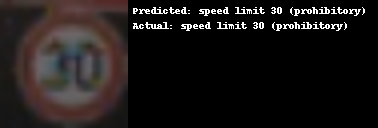

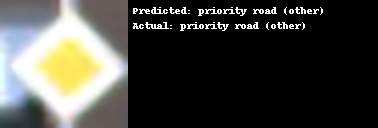

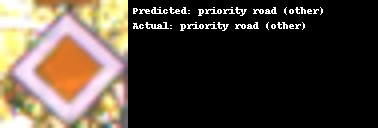

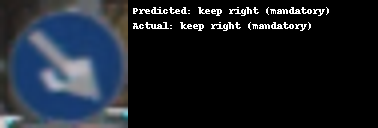

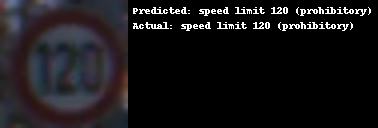

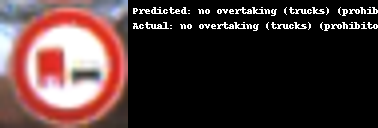

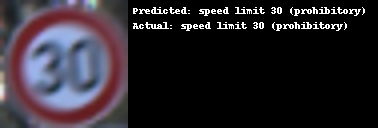

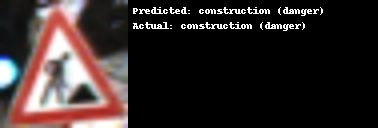

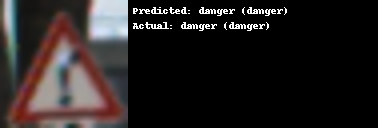

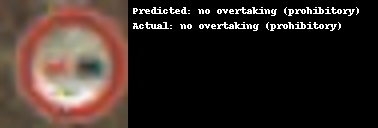

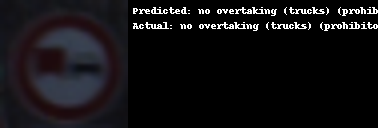

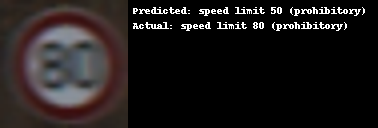

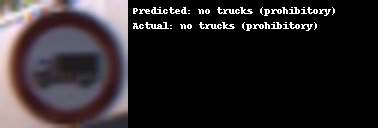

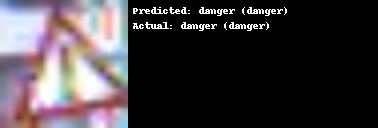

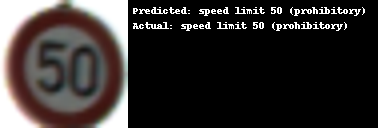

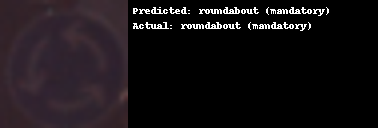

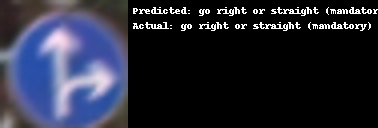

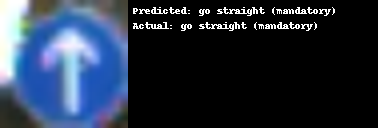

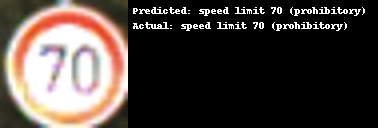

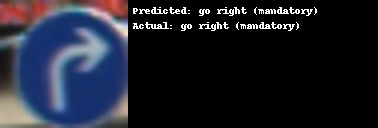

In [ ]:


# Usage example
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 43)  # Assuming 43 classes
predict_and_display_individual_test_images_pil_colab(model, weight_key='resnet50', num_images=20, image_size=128, text_width=250)


##6. Training with Pretrained MobileNet

In [ ]:
# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# MobileNetV2 uses a classifier named 'classifier' instead of 'fc' used by ResNet
# Its structure is different, so we replace the entire classifier module
# The in_features for the last layer is 1280 by default for MobileNetV2
model.classifier = nn.Sequential(
    nn.Linear(1280, 43)  # Adapt for 43 classes
)

# Assume you have a training_evaluation function defined as in your context
weight_key = 'mobilenet_v2'
# Ensure that the model architecture matches the one used during training
training_evaluation(model, weight_key, n_epochs=25)

Epoch 1: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s]


Epoch 1, Loss: 2.5441864132881165


Evaluating Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]


Accuracy after epoch 1: 36.21%


Epoch 2: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]


Epoch 2, Loss: 1.5439726412296295


Evaluating Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Accuracy after epoch 2: 51.85%


Epoch 3: 100%|██████████| 16/16 [00:03<00:00,  4.73it/s]


Epoch 3, Loss: 1.1213523969054222


Evaluating Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Accuracy after epoch 3: 62.14%


Epoch 4: 100%|██████████| 16/16 [00:03<00:00,  4.76it/s]


Epoch 4, Loss: 0.8554948754608631


Evaluating Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Accuracy after epoch 4: 69.14%


Epoch 5: 100%|██████████| 16/16 [00:03<00:00,  4.50it/s]


Epoch 5, Loss: 0.8158473558723927


Evaluating Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Accuracy after epoch 5: 72.43%


Epoch 6: 100%|██████████| 16/16 [00:03<00:00,  4.91it/s]


Epoch 6, Loss: 0.6922323480248451


Evaluating Epoch 6: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Accuracy after epoch 6: 72.43%


Epoch 7: 100%|██████████| 16/16 [00:03<00:00,  4.57it/s]


Epoch 7, Loss: 0.5909979399293661


Evaluating Epoch 7: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Accuracy after epoch 7: 76.13%


Epoch 8: 100%|██████████| 16/16 [00:03<00:00,  4.50it/s]


Epoch 8, Loss: 0.5273125879466534


Evaluating Epoch 8: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


Accuracy after epoch 8: 76.54%


Epoch 9: 100%|██████████| 16/16 [00:03<00:00,  4.82it/s]


Epoch 9, Loss: 0.4894693121314049


Evaluating Epoch 9: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Accuracy after epoch 9: 76.54%


Epoch 10: 100%|██████████| 16/16 [00:03<00:00,  4.81it/s]


Epoch 10, Loss: 0.39622190594673157


Evaluating Epoch 10: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Accuracy after epoch 10: 79.84%


Epoch 11: 100%|██████████| 16/16 [00:03<00:00,  4.54it/s]


Epoch 11, Loss: 0.40255906200036407


Evaluating Epoch 11: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Accuracy after epoch 11: 81.48%


Epoch 12: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]


Epoch 12, Loss: 0.3738764110021293


Evaluating Epoch 12: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Accuracy after epoch 12: 82.30%


Epoch 13: 100%|██████████| 16/16 [00:03<00:00,  4.91it/s]


Epoch 13, Loss: 0.36244070157408714


Evaluating Epoch 13: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Accuracy after epoch 13: 85.19%


Epoch 14: 100%|██████████| 16/16 [00:03<00:00,  4.72it/s]


Epoch 14, Loss: 0.2569278213195503


Evaluating Epoch 14: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Accuracy after epoch 14: 83.13%


Epoch 15: 100%|██████████| 16/16 [00:03<00:00,  4.64it/s]


Epoch 15, Loss: 0.30456357588991523


Evaluating Epoch 15: 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Accuracy after epoch 15: 83.54%


Epoch 16: 100%|██████████| 16/16 [00:03<00:00,  4.79it/s]


Epoch 16, Loss: 0.41477908939123154


Evaluating Epoch 16: 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Accuracy after epoch 16: 78.19%


Epoch 17: 100%|██████████| 16/16 [00:03<00:00,  4.74it/s]


Epoch 17, Loss: 0.37052603950724006


Evaluating Epoch 17: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Accuracy after epoch 17: 78.60%


Epoch 18: 100%|██████████| 16/16 [00:03<00:00,  4.57it/s]


Epoch 18, Loss: 0.2866097465157509


Evaluating Epoch 18: 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Accuracy after epoch 18: 88.07%


Epoch 19: 100%|██████████| 16/16 [00:03<00:00,  4.94it/s]


Epoch 19, Loss: 0.2705305959098041


Evaluating Epoch 19: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Accuracy after epoch 19: 85.60%


Epoch 20: 100%|██████████| 16/16 [00:03<00:00,  4.85it/s]


Epoch 20, Loss: 0.2726549096405506


Evaluating Epoch 20: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Accuracy after epoch 20: 83.13%


Epoch 21: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]


Epoch 21, Loss: 0.30102229258045554


Evaluating Epoch 21: 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Accuracy after epoch 21: 83.54%


Epoch 22: 100%|██████████| 16/16 [00:03<00:00,  4.81it/s]


Epoch 22, Loss: 0.2176273267250508


Evaluating Epoch 22: 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Accuracy after epoch 22: 85.60%


Epoch 23: 100%|██████████| 16/16 [00:03<00:00,  4.72it/s]


Epoch 23, Loss: 0.2608719835989177


Evaluating Epoch 23: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Accuracy after epoch 23: 84.36%


Epoch 24: 100%|██████████| 16/16 [00:03<00:00,  4.32it/s]


Epoch 24, Loss: 0.2889024051837623


Evaluating Epoch 24: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Accuracy after epoch 24: 84.36%


Epoch 25: 100%|██████████| 16/16 [00:03<00:00,  4.83it/s]


Epoch 25, Loss: 0.20323373284190893


Evaluating Epoch 25: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Accuracy after epoch 25: 88.07%
Training completed and model saved.


## 7. Testing with MobileNetV2

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Testing: 100%|██████████| 4/4 [00:13<00:00,  3.42s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/u

Accuracy of the model on the test images: 95.88%
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000        14
           2      1.000     1.000     1.000        25
           3      1.000     1.000     1.000         7
           4      1.000     1.000     1.000        14
           5      1.000     1.000     1.000        12
           6      1.000     1.000     1.000         7
           7      1.000     1.000     1.000        11
           8      0.938     1.000     0.968        15
           9      1.000     1.000     1.000        10
          10      1.000     1.000     1.000        18
          11      1.000     1.000     1.000         5
          12      1.000     1.000     1.000        16
          13      1.000     1.000     1.000        15
          14      1.000     0.833     0.909         6
          15      1.000     1.000     1.000         1
          16      1.000     1.00

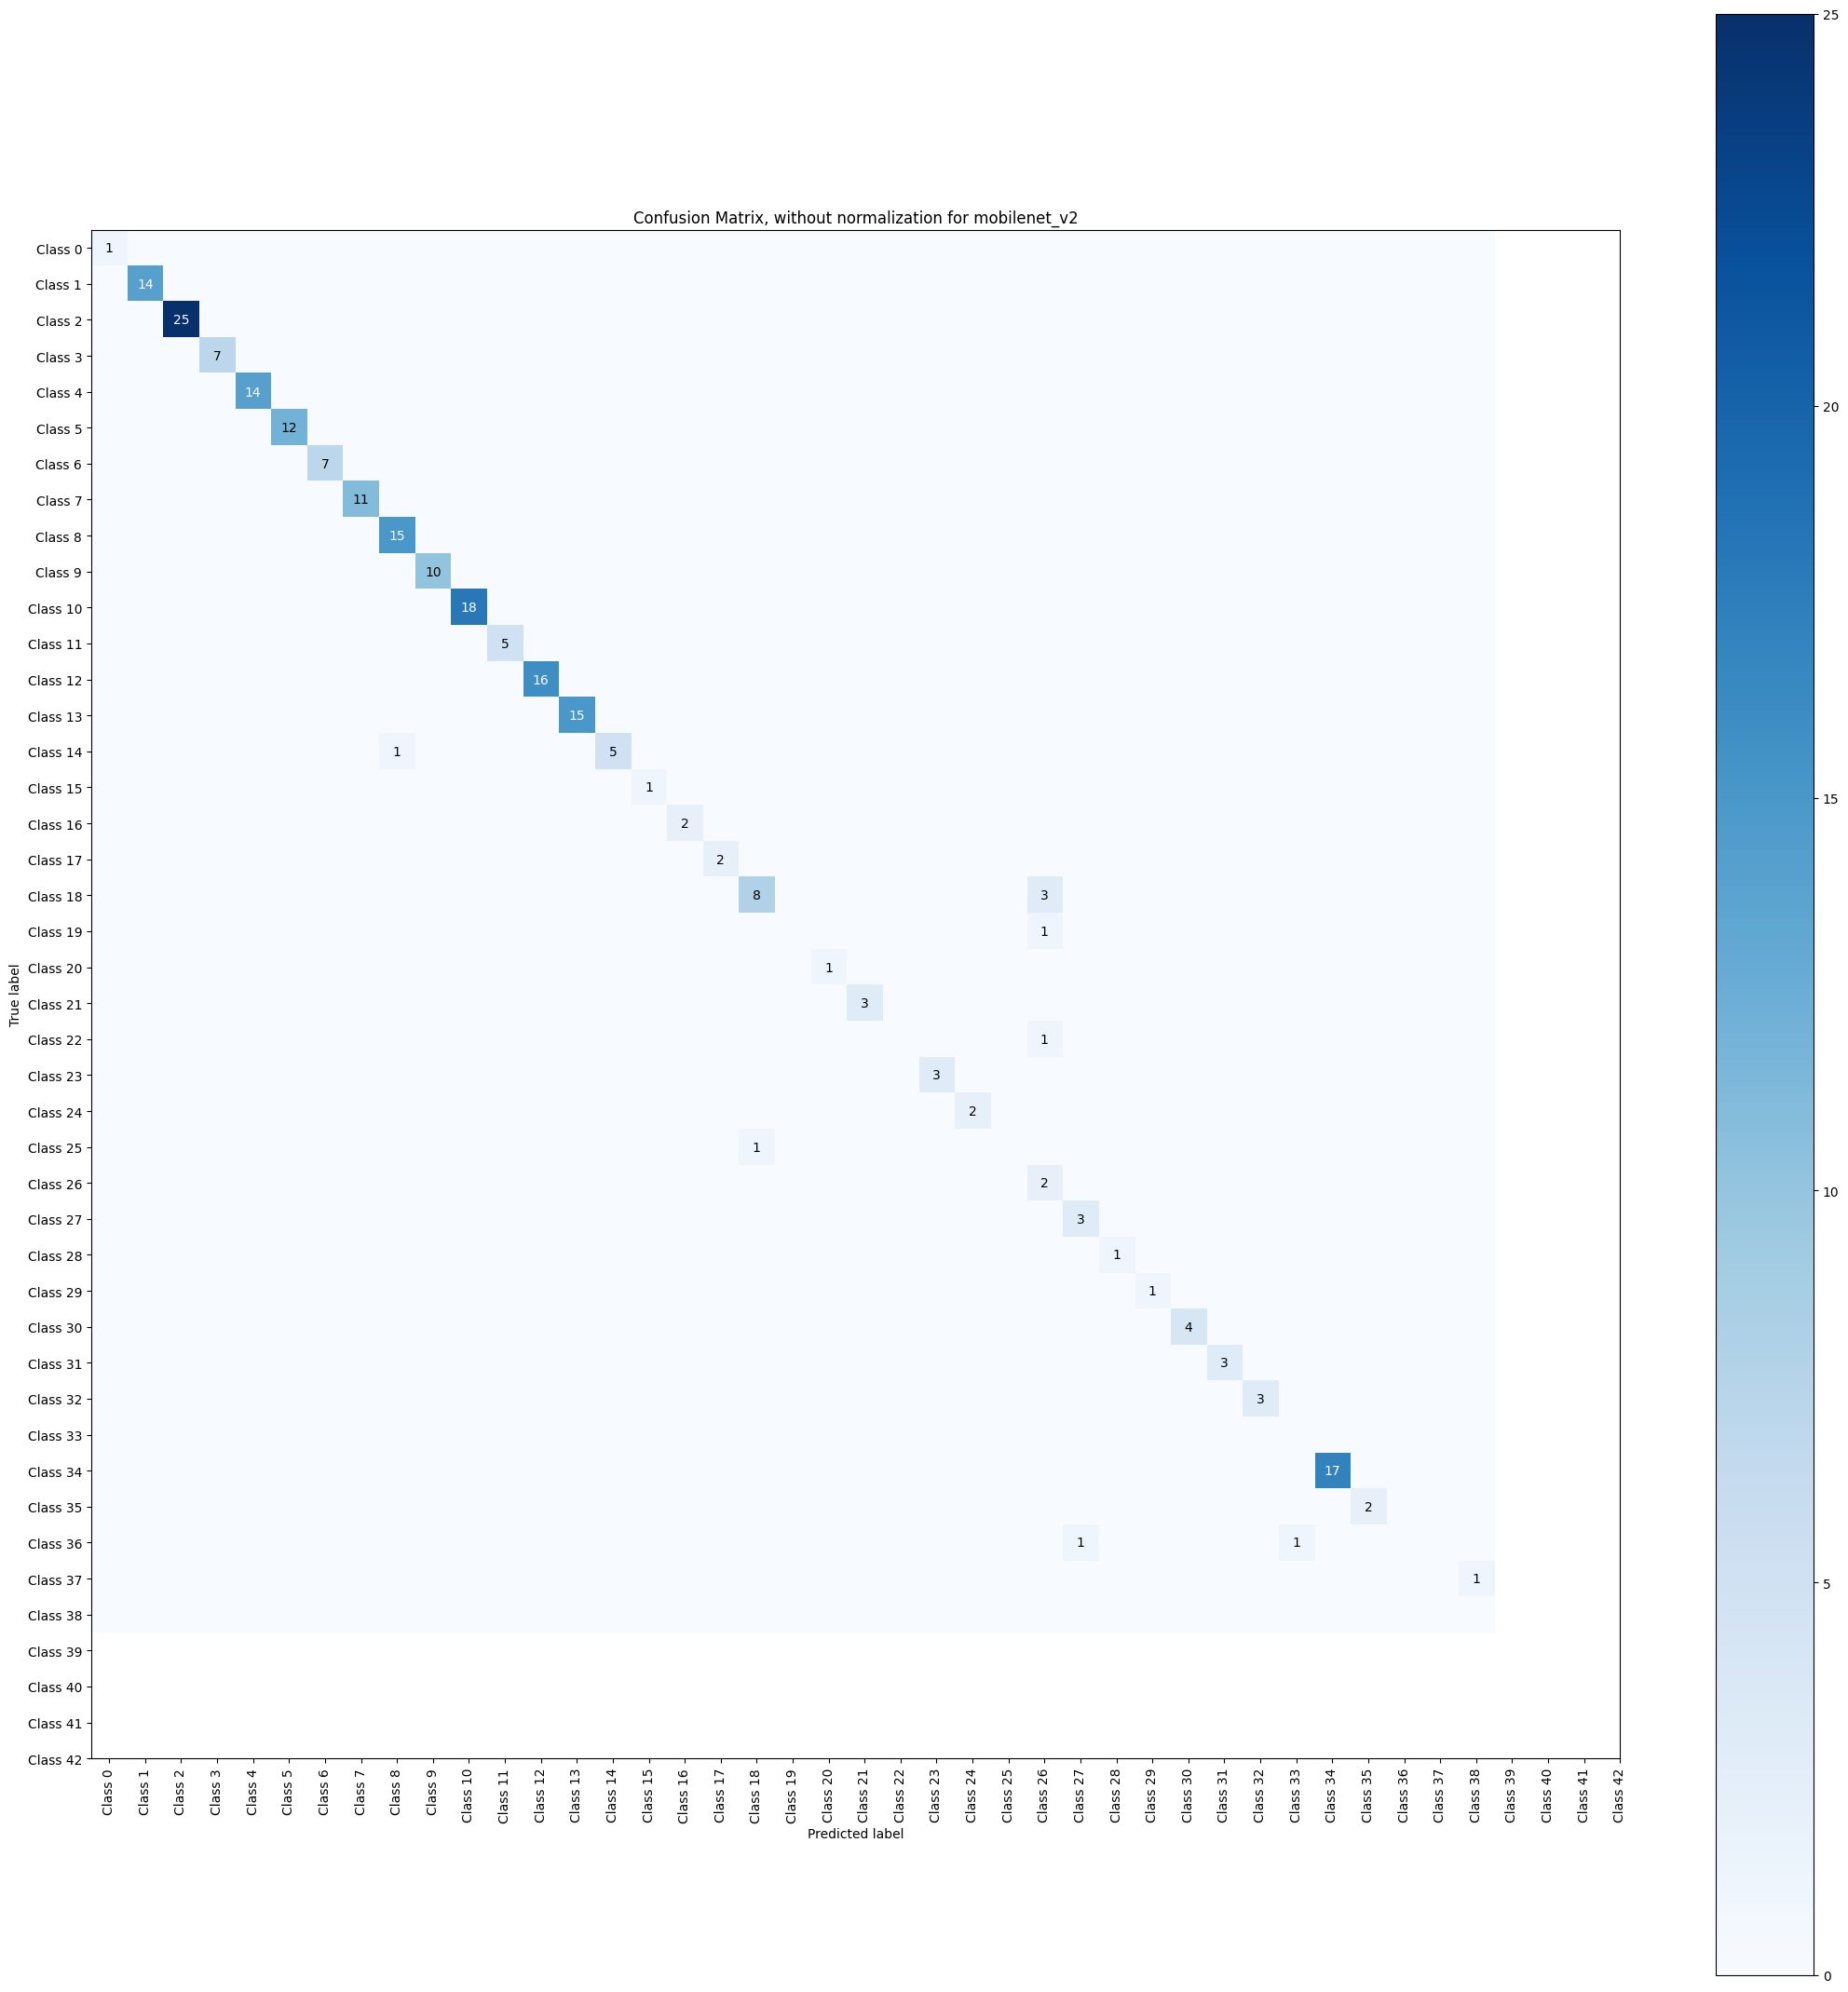

In [ ]:
from torchvision import models
import torch.nn as nn

# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Replace the classifier for testing
model.classifier = nn.Sequential(
    nn.Linear(1280, 43)  # Assuming 43 classes
)

# Assume you have a testing function defined as in your context
weight_key = 'mobilenet_v2'
testing(model, weight_key)


### 7.1 Prediction

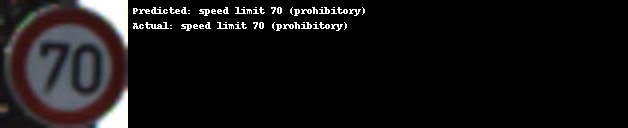

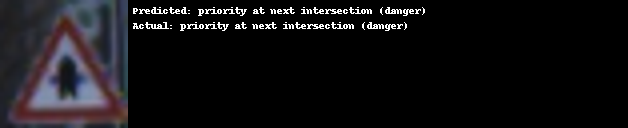

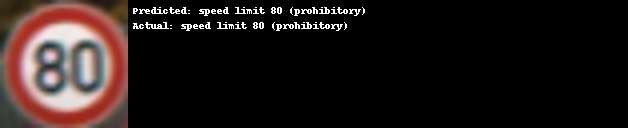

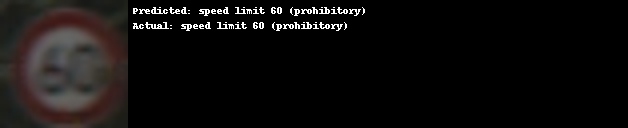

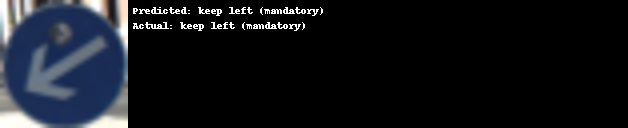

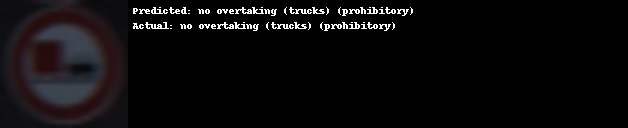

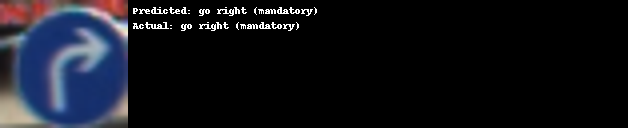

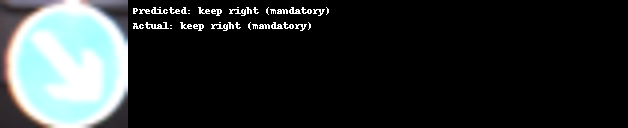

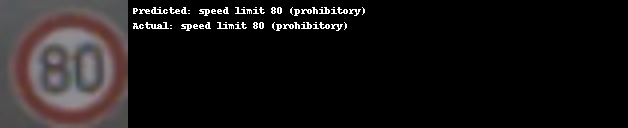

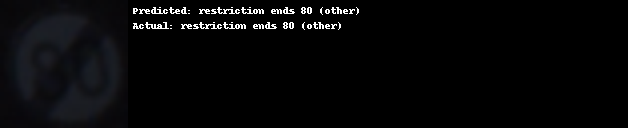

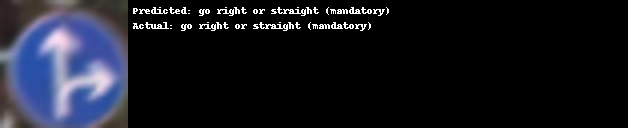

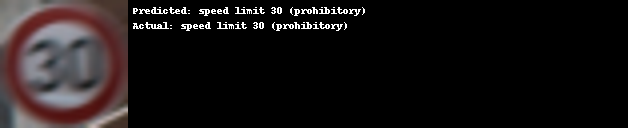

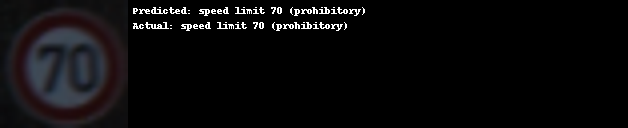

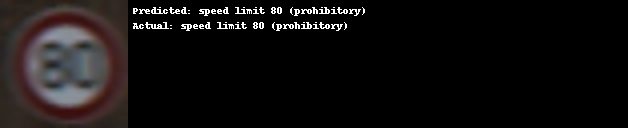

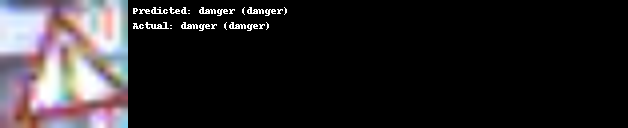

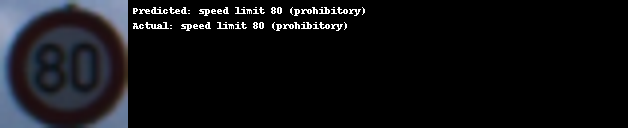

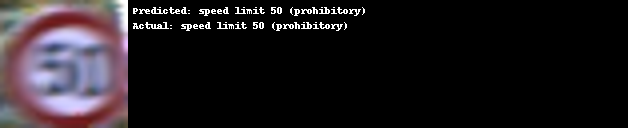

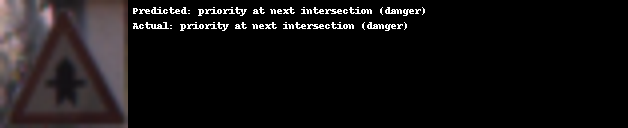

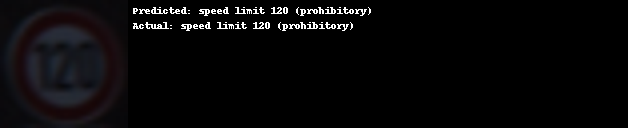

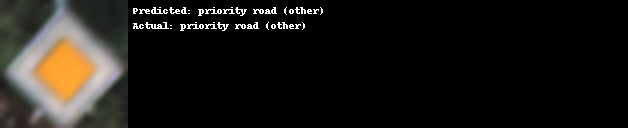

In [ ]:
predict_and_display_individual_test_images_pil_colab(model, weight_key, num_images=20, image_size=128, text_width=500)


##8. Building our own CNN Model: TS-Net

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import os
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F  # Import the functional API

class CustomCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc = nn.Linear(128, num_classes)  # Final FC layer

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.global_avg_pool(x)
        x = x.view(-1, 128)  # Flatten
        x = self.fc(x)
        return x


## 9. Training with Custom CNN

In [ ]:
# Assuming the CustomCNN class is already defined as per the previous instructions

# Model instantiation for training
model = CustomCNN(num_classes=43)
weight_key = 'custom_cnn'

# Assuming you have a function named 'training_evaluation' ready for training and validation
n_epochs = 5  # Specify the number of epochs you want to train for
training_evaluation(model, weight_key, n_epochs)


cuda:0


Epoch 1: 100%|██████████| 16/16 [04:22<00:00, 16.38s/it]


Epoch 1, Loss: 3.2486122846603394


Evaluating Epoch 1: 100%|██████████| 4/4 [03:01<00:00, 45.49s/it]


Accuracy after epoch 1: 21.81%


Epoch 2: 100%|██████████| 16/16 [00:01<00:00,  8.33it/s]


Epoch 2, Loss: 2.8105482310056686


Evaluating Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  8.81it/s]


Accuracy after epoch 2: 30.04%


Epoch 3: 100%|██████████| 16/16 [00:01<00:00,  8.37it/s]


Epoch 3, Loss: 2.5101090371608734


Evaluating Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  8.20it/s]


Accuracy after epoch 3: 41.56%


Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  7.98it/s]


Epoch 4, Loss: 2.289010599255562


Evaluating Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  8.21it/s]


Accuracy after epoch 4: 37.45%


Epoch 5: 100%|██████████| 16/16 [00:01<00:00,  8.35it/s]


Epoch 5, Loss: 2.1063384637236595


Evaluating Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  7.46it/s]

Accuracy after epoch 5: 37.45%
Training completed and model saved.


In [ ]:
# Assuming the CustomCNN class is already defined as per the previous instructions

# Model instantiation for training
model = CustomCNN(num_classes=43)
weight_key = 'custom_cnn'

# Assuming you have a function named 'training_evaluation' ready for training and validation
n_epochs = 100  # Specify the number of epochs you want to train for
training_evaluation(model, weight_key, n_epochs)


cuda:0


Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]


Epoch 1, Loss: 3.326849102973938


Evaluating Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  7.32it/s]


Accuracy after epoch 1: 18.52%


Epoch 2: 100%|██████████| 16/16 [00:01<00:00,  8.34it/s]


Epoch 2, Loss: 2.8627475798130035


Evaluating Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  8.21it/s]


Accuracy after epoch 2: 25.10%


Epoch 3: 100%|██████████| 16/16 [00:01<00:00,  8.19it/s]


Epoch 3, Loss: 2.6208330541849136


Evaluating Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  8.81it/s]


Accuracy after epoch 3: 32.51%


Epoch 4: 100%|██████████| 16/16 [00:01<00:00,  8.46it/s]


Epoch 4, Loss: 2.4336918890476227


Evaluating Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  8.70it/s]


Accuracy after epoch 4: 33.33%


Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  7.94it/s]


Epoch 5, Loss: 2.2121905609965324


Evaluating Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  8.40it/s]


Accuracy after epoch 5: 39.92%


Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  7.60it/s]


Epoch 6, Loss: 2.0840216651558876


Evaluating Epoch 6: 100%|██████████| 4/4 [00:00<00:00,  7.50it/s]


Accuracy after epoch 6: 37.45%


Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  7.95it/s]


Epoch 7, Loss: 1.8974492996931076


Evaluating Epoch 7: 100%|██████████| 4/4 [00:00<00:00,  7.55it/s]


Accuracy after epoch 7: 45.68%


Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  7.22it/s]


Epoch 8, Loss: 1.8143965676426888


Evaluating Epoch 8: 100%|██████████| 4/4 [00:00<00:00,  8.54it/s]


Accuracy after epoch 8: 41.56%


Epoch 9: 100%|██████████| 16/16 [00:01<00:00,  8.45it/s]


Epoch 9, Loss: 1.719734750688076


Evaluating Epoch 9: 100%|██████████| 4/4 [00:00<00:00,  7.99it/s]


Accuracy after epoch 9: 51.03%


Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  7.60it/s]


Epoch 10, Loss: 1.580598071217537


Evaluating Epoch 10: 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]


Accuracy after epoch 10: 43.62%


Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  7.72it/s]


Epoch 11, Loss: 1.539920412003994


Evaluating Epoch 11: 100%|██████████| 4/4 [00:00<00:00,  7.87it/s]


Accuracy after epoch 11: 53.50%


Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  7.73it/s]


Epoch 12, Loss: 1.4050995409488678


Evaluating Epoch 12: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


Accuracy after epoch 12: 52.26%


Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  7.47it/s]


Epoch 13, Loss: 1.3227283507585526


Evaluating Epoch 13: 100%|██████████| 4/4 [00:00<00:00,  8.26it/s]


Accuracy after epoch 13: 47.74%


Epoch 14: 100%|██████████| 16/16 [00:01<00:00,  8.03it/s]


Epoch 14, Loss: 1.2713829725980759


Evaluating Epoch 14: 100%|██████████| 4/4 [00:00<00:00,  8.47it/s]


Accuracy after epoch 14: 50.62%


Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  7.87it/s]


Epoch 15, Loss: 1.2129105105996132


Evaluating Epoch 15: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]


Accuracy after epoch 15: 49.38%


Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  7.16it/s]


Epoch 16, Loss: 1.187403704971075


Evaluating Epoch 16: 100%|██████████| 4/4 [00:00<00:00,  7.97it/s]


Accuracy after epoch 16: 54.73%


Epoch 17: 100%|██████████| 16/16 [00:01<00:00,  8.05it/s]


Epoch 17, Loss: 1.1070847921073437


Evaluating Epoch 17: 100%|██████████| 4/4 [00:00<00:00,  8.50it/s]


Accuracy after epoch 17: 68.31%


Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  7.50it/s]


Epoch 18, Loss: 1.0286216028034687


Evaluating Epoch 18: 100%|██████████| 4/4 [00:00<00:00,  7.32it/s]


Accuracy after epoch 18: 66.67%


Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  7.84it/s]


Epoch 19, Loss: 0.929377268999815


Evaluating Epoch 19: 100%|██████████| 4/4 [00:00<00:00,  9.58it/s]


Accuracy after epoch 19: 55.97%


Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  7.68it/s]


Epoch 20, Loss: 0.9303091503679752


Evaluating Epoch 20: 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]


Accuracy after epoch 20: 65.84%


Epoch 21: 100%|██████████| 16/16 [00:01<00:00,  8.27it/s]


Epoch 21, Loss: 0.8781453743577003


Evaluating Epoch 21: 100%|██████████| 4/4 [00:00<00:00,  8.48it/s]


Accuracy after epoch 21: 65.43%


Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  7.85it/s]


Epoch 22, Loss: 0.882192350924015


Evaluating Epoch 22: 100%|██████████| 4/4 [00:00<00:00,  8.75it/s]


Accuracy after epoch 22: 60.49%


Epoch 23: 100%|██████████| 16/16 [00:01<00:00,  8.17it/s]


Epoch 23, Loss: 0.8060095645487309


Evaluating Epoch 23: 100%|██████████| 4/4 [00:00<00:00,  9.09it/s]


Accuracy after epoch 23: 66.67%


Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  7.80it/s]


Epoch 24, Loss: 0.7352965585887432


Evaluating Epoch 24: 100%|██████████| 4/4 [00:00<00:00,  7.47it/s]


Accuracy after epoch 24: 59.67%


Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  7.55it/s]


Epoch 25, Loss: 0.7009357083588839


Evaluating Epoch 25: 100%|██████████| 4/4 [00:00<00:00,  7.51it/s]


Accuracy after epoch 25: 65.84%


Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  7.67it/s]


Epoch 26, Loss: 0.6798791028559208


Evaluating Epoch 26: 100%|██████████| 4/4 [00:00<00:00,  8.49it/s]


Accuracy after epoch 26: 70.37%


Epoch 27: 100%|██████████| 16/16 [00:01<00:00,  8.21it/s]


Epoch 27, Loss: 0.6440872550010681


Evaluating Epoch 27: 100%|██████████| 4/4 [00:00<00:00,  8.78it/s]


Accuracy after epoch 27: 73.25%


Epoch 28: 100%|██████████| 16/16 [00:01<00:00,  8.25it/s]


Epoch 28, Loss: 0.6243880279362202


Evaluating Epoch 28: 100%|██████████| 4/4 [00:00<00:00,  7.75it/s]


Accuracy after epoch 28: 72.43%


Epoch 29: 100%|██████████| 16/16 [00:02<00:00,  7.42it/s]


Epoch 29, Loss: 0.6084491591900587


Evaluating Epoch 29: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s]


Accuracy after epoch 29: 63.79%


Epoch 30: 100%|██████████| 16/16 [00:02<00:00,  7.48it/s]


Epoch 30, Loss: 0.5998502280563116


Evaluating Epoch 30: 100%|██████████| 4/4 [00:00<00:00,  8.53it/s]


Accuracy after epoch 30: 72.02%


Epoch 31: 100%|██████████| 16/16 [00:02<00:00,  8.00it/s]


Epoch 31, Loss: 0.5293141286820173


Evaluating Epoch 31: 100%|██████████| 4/4 [00:00<00:00,  8.91it/s]


Accuracy after epoch 31: 71.19%


Epoch 32: 100%|██████████| 16/16 [00:01<00:00,  8.78it/s]


Epoch 32, Loss: 0.5122009124606848


Evaluating Epoch 32: 100%|██████████| 4/4 [00:00<00:00,  8.42it/s]


Accuracy after epoch 32: 71.60%


Epoch 33: 100%|██████████| 16/16 [00:01<00:00,  8.72it/s]


Epoch 33, Loss: 0.48453239910304546


Evaluating Epoch 33: 100%|██████████| 4/4 [00:00<00:00,  7.65it/s]


Accuracy after epoch 33: 76.13%


Epoch 34: 100%|██████████| 16/16 [00:01<00:00,  8.55it/s]


Epoch 34, Loss: 0.4842081591486931


Evaluating Epoch 34: 100%|██████████| 4/4 [00:00<00:00,  8.03it/s]


Accuracy after epoch 34: 76.13%


Epoch 35: 100%|██████████| 16/16 [00:02<00:00,  7.16it/s]


Epoch 35, Loss: 0.46523987129330635


Evaluating Epoch 35: 100%|██████████| 4/4 [00:00<00:00,  8.04it/s]


Accuracy after epoch 35: 72.84%


Epoch 36: 100%|██████████| 16/16 [00:02<00:00,  7.55it/s]


Epoch 36, Loss: 0.42946450412273407


Evaluating Epoch 36: 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]


Accuracy after epoch 36: 71.60%


Epoch 37: 100%|██████████| 16/16 [00:02<00:00,  7.56it/s]


Epoch 37, Loss: 0.40791104547679424


Evaluating Epoch 37: 100%|██████████| 4/4 [00:00<00:00,  7.92it/s]


Accuracy after epoch 37: 79.42%


Epoch 38: 100%|██████████| 16/16 [00:02<00:00,  7.78it/s]


Epoch 38, Loss: 0.368059491738677


Evaluating Epoch 38: 100%|██████████| 4/4 [00:00<00:00,  8.36it/s]


Accuracy after epoch 38: 71.60%


Epoch 39: 100%|██████████| 16/16 [00:02<00:00,  7.55it/s]


Epoch 39, Loss: 0.3751376513391733


Evaluating Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  7.65it/s]


Accuracy after epoch 39: 77.78%


Epoch 40: 100%|██████████| 16/16 [00:02<00:00,  7.96it/s]


Epoch 40, Loss: 0.34722365252673626


Evaluating Epoch 40: 100%|██████████| 4/4 [00:00<00:00,  8.76it/s]


Accuracy after epoch 40: 79.42%


Epoch 41: 100%|██████████| 16/16 [00:02<00:00,  7.65it/s]


Epoch 41, Loss: 0.3356038872152567


Evaluating Epoch 41: 100%|██████████| 4/4 [00:00<00:00,  7.61it/s]


Accuracy after epoch 41: 79.84%


Epoch 42: 100%|██████████| 16/16 [00:02<00:00,  7.81it/s]


Epoch 42, Loss: 0.295487392693758


Evaluating Epoch 42: 100%|██████████| 4/4 [00:00<00:00,  9.27it/s]


Accuracy after epoch 42: 80.66%


Epoch 43: 100%|██████████| 16/16 [00:02<00:00,  7.23it/s]


Epoch 43, Loss: 0.29132084734737873


Evaluating Epoch 43: 100%|██████████| 4/4 [00:00<00:00,  8.05it/s]


Accuracy after epoch 43: 76.95%


Epoch 44: 100%|██████████| 16/16 [00:02<00:00,  7.83it/s]


Epoch 44, Loss: 0.3187466552481055


Evaluating Epoch 44: 100%|██████████| 4/4 [00:00<00:00,  7.60it/s]


Accuracy after epoch 44: 77.37%


Epoch 45: 100%|██████████| 16/16 [00:02<00:00,  7.52it/s]


Epoch 45, Loss: 0.3285613842308521


Evaluating Epoch 45: 100%|██████████| 4/4 [00:00<00:00,  8.65it/s]


Accuracy after epoch 45: 79.01%


Epoch 46: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s]


Epoch 46, Loss: 0.28127791825681925


Evaluating Epoch 46: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]


Accuracy after epoch 46: 79.01%


Epoch 47: 100%|██████████| 16/16 [00:02<00:00,  7.59it/s]


Epoch 47, Loss: 0.25756104849278927


Evaluating Epoch 47: 100%|██████████| 4/4 [00:00<00:00,  7.28it/s]


Accuracy after epoch 47: 75.72%


Epoch 48: 100%|██████████| 16/16 [00:02<00:00,  7.58it/s]


Epoch 48, Loss: 0.22961215721443295


Evaluating Epoch 48: 100%|██████████| 4/4 [00:00<00:00,  8.39it/s]


Accuracy after epoch 48: 79.42%


Epoch 49: 100%|██████████| 16/16 [00:02<00:00,  7.83it/s]


Epoch 49, Loss: 0.21540274936705828


Evaluating Epoch 49: 100%|██████████| 4/4 [00:00<00:00,  8.26it/s]


Accuracy after epoch 49: 83.95%


Epoch 50: 100%|██████████| 16/16 [00:01<00:00,  8.24it/s]


Epoch 50, Loss: 0.22161387465894222


Evaluating Epoch 50: 100%|██████████| 4/4 [00:00<00:00,  7.73it/s]


Accuracy after epoch 50: 79.84%


Epoch 51: 100%|██████████| 16/16 [00:02<00:00,  7.74it/s]


Epoch 51, Loss: 0.2250107442960143


Evaluating Epoch 51: 100%|██████████| 4/4 [00:00<00:00,  7.85it/s]


Accuracy after epoch 51: 83.95%


Epoch 52: 100%|██████████| 16/16 [00:02<00:00,  7.71it/s]


Epoch 52, Loss: 0.20416084863245487


Evaluating Epoch 52: 100%|██████████| 4/4 [00:00<00:00,  7.60it/s]


Accuracy after epoch 52: 76.13%


Epoch 53: 100%|██████████| 16/16 [00:02<00:00,  7.97it/s]


Epoch 53, Loss: 0.20707760378718376


Evaluating Epoch 53: 100%|██████████| 4/4 [00:00<00:00,  8.07it/s]


Accuracy after epoch 53: 80.25%


Epoch 54: 100%|██████████| 16/16 [00:02<00:00,  7.83it/s]


Epoch 54, Loss: 0.20210301643237472


Evaluating Epoch 54: 100%|██████████| 4/4 [00:00<00:00,  8.49it/s]


Accuracy after epoch 54: 79.42%


Epoch 55: 100%|██████████| 16/16 [00:01<00:00,  8.05it/s]


Epoch 55, Loss: 0.2008919445797801


Evaluating Epoch 55: 100%|██████████| 4/4 [00:00<00:00,  7.48it/s]


Accuracy after epoch 55: 71.19%


Epoch 56: 100%|██████████| 16/16 [00:01<00:00,  8.16it/s]


Epoch 56, Loss: 0.19637618865817785


Evaluating Epoch 56: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s]


Accuracy after epoch 56: 78.19%


Epoch 57: 100%|██████████| 16/16 [00:01<00:00,  8.58it/s]


Epoch 57, Loss: 0.2225095871835947


Evaluating Epoch 57: 100%|██████████| 4/4 [00:00<00:00,  8.08it/s]


Accuracy after epoch 57: 66.67%


Epoch 58: 100%|██████████| 16/16 [00:02<00:00,  7.64it/s]


Epoch 58, Loss: 0.17252960102632642


Evaluating Epoch 58: 100%|██████████| 4/4 [00:00<00:00,  7.70it/s]


Accuracy after epoch 58: 78.60%


Epoch 59: 100%|██████████| 16/16 [00:02<00:00,  7.44it/s]


Epoch 59, Loss: 0.16965119959786534


Evaluating Epoch 59: 100%|██████████| 4/4 [00:00<00:00,  8.25it/s]


Accuracy after epoch 59: 72.02%


Epoch 60: 100%|██████████| 16/16 [00:01<00:00,  8.38it/s]


Epoch 60, Loss: 0.18464228603988886


Evaluating Epoch 60: 100%|██████████| 4/4 [00:00<00:00,  7.55it/s]


Accuracy after epoch 60: 59.67%


Epoch 61: 100%|██████████| 16/16 [00:02<00:00,  7.93it/s]


Epoch 61, Loss: 0.16690347949042916


Evaluating Epoch 61: 100%|██████████| 4/4 [00:00<00:00,  8.20it/s]


Accuracy after epoch 61: 79.84%


Epoch 62: 100%|██████████| 16/16 [00:02<00:00,  7.82it/s]


Epoch 62, Loss: 0.14123634435236454


Evaluating Epoch 62: 100%|██████████| 4/4 [00:00<00:00,  9.23it/s]


Accuracy after epoch 62: 80.25%


Epoch 63: 100%|██████████| 16/16 [00:02<00:00,  7.77it/s]


Epoch 63, Loss: 0.14930995786562562


Evaluating Epoch 63: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]


Accuracy after epoch 63: 75.72%


Epoch 64: 100%|██████████| 16/16 [00:02<00:00,  7.44it/s]


Epoch 64, Loss: 0.130854407325387


Evaluating Epoch 64: 100%|██████████| 4/4 [00:00<00:00,  8.10it/s]


Accuracy after epoch 64: 82.30%


Epoch 65: 100%|██████████| 16/16 [00:02<00:00,  7.30it/s]


Epoch 65, Loss: 0.1187019778881222


Evaluating Epoch 65: 100%|██████████| 4/4 [00:00<00:00,  8.70it/s]


Accuracy after epoch 65: 79.84%


Epoch 66: 100%|██████████| 16/16 [00:01<00:00,  8.52it/s]


Epoch 66, Loss: 0.12090287823230028


Evaluating Epoch 66: 100%|██████████| 4/4 [00:00<00:00,  7.45it/s]


Accuracy after epoch 66: 81.48%


Epoch 67: 100%|██████████| 16/16 [00:01<00:00,  8.17it/s]


Epoch 67, Loss: 0.1142472627107054


Evaluating Epoch 67: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s]


Accuracy after epoch 67: 84.36%


Epoch 68: 100%|██████████| 16/16 [00:01<00:00,  8.09it/s]


Epoch 68, Loss: 0.1080299410969019


Evaluating Epoch 68: 100%|██████████| 4/4 [00:00<00:00,  7.86it/s]


Accuracy after epoch 68: 83.13%


Epoch 69: 100%|██████████| 16/16 [00:02<00:00,  7.59it/s]


Epoch 69, Loss: 0.12540946481749415


Evaluating Epoch 69: 100%|██████████| 4/4 [00:00<00:00,  8.10it/s]


Accuracy after epoch 69: 81.48%


Epoch 70: 100%|██████████| 16/16 [00:01<00:00,  8.51it/s]


Epoch 70, Loss: 0.17321034148335457


Evaluating Epoch 70: 100%|██████████| 4/4 [00:00<00:00,  9.01it/s]


Accuracy after epoch 70: 75.72%


Epoch 71: 100%|██████████| 16/16 [00:02<00:00,  7.60it/s]


Epoch 71, Loss: 0.1272635692730546


Evaluating Epoch 71: 100%|██████████| 4/4 [00:00<00:00,  8.68it/s]


Accuracy after epoch 71: 81.07%


Epoch 72: 100%|██████████| 16/16 [00:01<00:00,  8.43it/s]


Epoch 72, Loss: 0.11778868641704321


Evaluating Epoch 72: 100%|██████████| 4/4 [00:00<00:00,  8.77it/s]


Accuracy after epoch 72: 65.43%


Epoch 73: 100%|██████████| 16/16 [00:02<00:00,  7.89it/s]


Epoch 73, Loss: 0.17109656427055597


Evaluating Epoch 73: 100%|██████████| 4/4 [00:00<00:00,  7.59it/s]


Accuracy after epoch 73: 80.25%


Epoch 74: 100%|██████████| 16/16 [00:02<00:00,  7.90it/s]


Epoch 74, Loss: 0.11870443169027567


Evaluating Epoch 74: 100%|██████████| 4/4 [00:00<00:00,  8.12it/s]


Accuracy after epoch 74: 80.66%


Epoch 75: 100%|██████████| 16/16 [00:02<00:00,  7.58it/s]


Epoch 75, Loss: 0.1084680303465575


Evaluating Epoch 75: 100%|██████████| 4/4 [00:00<00:00,  8.88it/s]


Accuracy after epoch 75: 79.42%


Epoch 76: 100%|██████████| 16/16 [00:02<00:00,  7.30it/s]


Epoch 76, Loss: 0.1265665888786316


Evaluating Epoch 76: 100%|██████████| 4/4 [00:00<00:00,  7.74it/s]


Accuracy after epoch 76: 72.84%


Epoch 77: 100%|██████████| 16/16 [00:01<00:00,  8.52it/s]


Epoch 77, Loss: 0.10952202044427395


Evaluating Epoch 77: 100%|██████████| 4/4 [00:00<00:00,  9.18it/s]


Accuracy after epoch 77: 76.13%


Epoch 78: 100%|██████████| 16/16 [00:02<00:00,  7.74it/s]


Epoch 78, Loss: 0.09717237576842308


Evaluating Epoch 78: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]


Accuracy after epoch 78: 78.19%


Epoch 79: 100%|██████████| 16/16 [00:02<00:00,  7.93it/s]


Epoch 79, Loss: 0.07311845477670431


Evaluating Epoch 79: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s]


Accuracy after epoch 79: 86.01%


Epoch 80: 100%|██████████| 16/16 [00:01<00:00,  8.39it/s]


Epoch 80, Loss: 0.06719018891453743


Evaluating Epoch 80: 100%|██████████| 4/4 [00:00<00:00,  9.23it/s]


Accuracy after epoch 80: 89.71%


Epoch 81: 100%|██████████| 16/16 [00:01<00:00,  8.29it/s]


Epoch 81, Loss: 0.07291862438432872


Evaluating Epoch 81: 100%|██████████| 4/4 [00:00<00:00,  8.90it/s]


Accuracy after epoch 81: 86.42%


Epoch 82: 100%|██████████| 16/16 [00:01<00:00,  8.33it/s]


Epoch 82, Loss: 0.07507068640552461


Evaluating Epoch 82: 100%|██████████| 4/4 [00:00<00:00,  8.47it/s]


Accuracy after epoch 82: 87.24%


Epoch 83: 100%|██████████| 16/16 [00:02<00:00,  7.76it/s]


Epoch 83, Loss: 0.06935038045048714


Evaluating Epoch 83: 100%|██████████| 4/4 [00:00<00:00,  8.00it/s]


Accuracy after epoch 83: 88.89%


Epoch 84: 100%|██████████| 16/16 [00:01<00:00,  8.19it/s]


Epoch 84, Loss: 0.08353612804785371


Evaluating Epoch 84: 100%|██████████| 4/4 [00:00<00:00,  8.80it/s]


Accuracy after epoch 84: 72.43%


Epoch 85: 100%|██████████| 16/16 [00:02<00:00,  7.81it/s]


Epoch 85, Loss: 0.08818974113091826


Evaluating Epoch 85: 100%|██████████| 4/4 [00:00<00:00,  7.85it/s]


Accuracy after epoch 85: 73.25%


Epoch 86: 100%|██████████| 16/16 [00:01<00:00,  8.08it/s]


Epoch 86, Loss: 0.07591179199516773


Evaluating Epoch 86: 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]


Accuracy after epoch 86: 81.48%


Epoch 87: 100%|██████████| 16/16 [00:02<00:00,  7.73it/s]


Epoch 87, Loss: 0.0676546620670706


Evaluating Epoch 87: 100%|██████████| 4/4 [00:00<00:00,  8.08it/s]


Accuracy after epoch 87: 85.19%


Epoch 88: 100%|██████████| 16/16 [00:02<00:00,  7.52it/s]


Epoch 88, Loss: 0.05986942315939814


Evaluating Epoch 88: 100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


Accuracy after epoch 88: 78.60%


Epoch 89: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


Epoch 89, Loss: 0.08311984711326659


Evaluating Epoch 89: 100%|██████████| 4/4 [00:00<00:00,  7.86it/s]


Accuracy after epoch 89: 71.19%


Epoch 90: 100%|██████████| 16/16 [00:02<00:00,  7.78it/s]


Epoch 90, Loss: 0.07125325547531247


Evaluating Epoch 90: 100%|██████████| 4/4 [00:00<00:00,  8.48it/s]


Accuracy after epoch 90: 81.89%


Epoch 91: 100%|██████████| 16/16 [00:01<00:00,  8.14it/s]


Epoch 91, Loss: 0.0608522891998291


Evaluating Epoch 91: 100%|██████████| 4/4 [00:00<00:00,  8.69it/s]


Accuracy after epoch 91: 84.77%


Epoch 92: 100%|██████████| 16/16 [00:01<00:00,  8.44it/s]


Epoch 92, Loss: 0.05362992768641561


Evaluating Epoch 92: 100%|██████████| 4/4 [00:00<00:00,  8.85it/s]


Accuracy after epoch 92: 86.01%


Epoch 93: 100%|██████████| 16/16 [00:02<00:00,  7.36it/s]


Epoch 93, Loss: 0.0523811315651983


Evaluating Epoch 93: 100%|██████████| 4/4 [00:00<00:00,  8.63it/s]


Accuracy after epoch 93: 85.19%


Epoch 94: 100%|██████████| 16/16 [00:01<00:00,  8.14it/s]


Epoch 94, Loss: 0.04785809281747788


Evaluating Epoch 94: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]


Accuracy after epoch 94: 86.83%


Epoch 95: 100%|██████████| 16/16 [00:01<00:00,  8.13it/s]


Epoch 95, Loss: 0.04193491081241518


Evaluating Epoch 95: 100%|██████████| 4/4 [00:00<00:00,  8.65it/s]


Accuracy after epoch 95: 82.72%


Epoch 96: 100%|██████████| 16/16 [00:02<00:00,  7.34it/s]


Epoch 96, Loss: 0.09843586315400898


Evaluating Epoch 96: 100%|██████████| 4/4 [00:00<00:00,  7.37it/s]


Accuracy after epoch 96: 68.72%


Epoch 97: 100%|██████████| 16/16 [00:02<00:00,  7.45it/s]


Epoch 97, Loss: 0.09355134959332645


Evaluating Epoch 97: 100%|██████████| 4/4 [00:00<00:00,  7.49it/s]


Accuracy after epoch 97: 81.07%


Epoch 98: 100%|██████████| 16/16 [00:02<00:00,  7.83it/s]


Epoch 98, Loss: 0.09239210048690438


Evaluating Epoch 98: 100%|██████████| 4/4 [00:00<00:00,  7.91it/s]


Accuracy after epoch 98: 79.42%


Epoch 99: 100%|██████████| 16/16 [00:01<00:00,  8.08it/s]


Epoch 99, Loss: 0.09581748000346124


Evaluating Epoch 99: 100%|██████████| 4/4 [00:00<00:00,  9.10it/s]


Accuracy after epoch 99: 83.13%


Epoch 100: 100%|██████████| 16/16 [00:02<00:00,  7.98it/s]


Epoch 100, Loss: 0.09139936580322683


Evaluating Epoch 100: 100%|██████████| 4/4 [00:00<00:00,  9.82it/s]

Accuracy after epoch 100: 81.07%
Training completed and model saved.


## 10. Testing with Custom CNN

Testing: 100%|██████████| 4/4 [00:00<00:00,  7.97it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of the model on the test images: 81.07%
              precision    recall  f1-score   support

           1      0.947     1.000     0.973        18
           2      1.000     0.917     0.957        12
           3      0.750     1.000     0.857         3
           4      0.917     1.000     0.957        11
           5      1.000     0.556     0.714         9
           6      1.000     0.286     0.444         7
           7      0.800     0.889     0.842         9
           8      0.800     0.800     0.800        10
           9      1.000     0.625     0.769         8
          10      0.812     1.000     0.897        13
          11      0.455     1.000     0.625         5
          12      0.800     1.000     0.889        20
          13      0.947     0.900     0.923        20
          14      1.000     1.000     1.000         6
          15      1.000     0.667     0.800         3
          17      1.000     1.000     1.000         6
          18      1.000     0.75

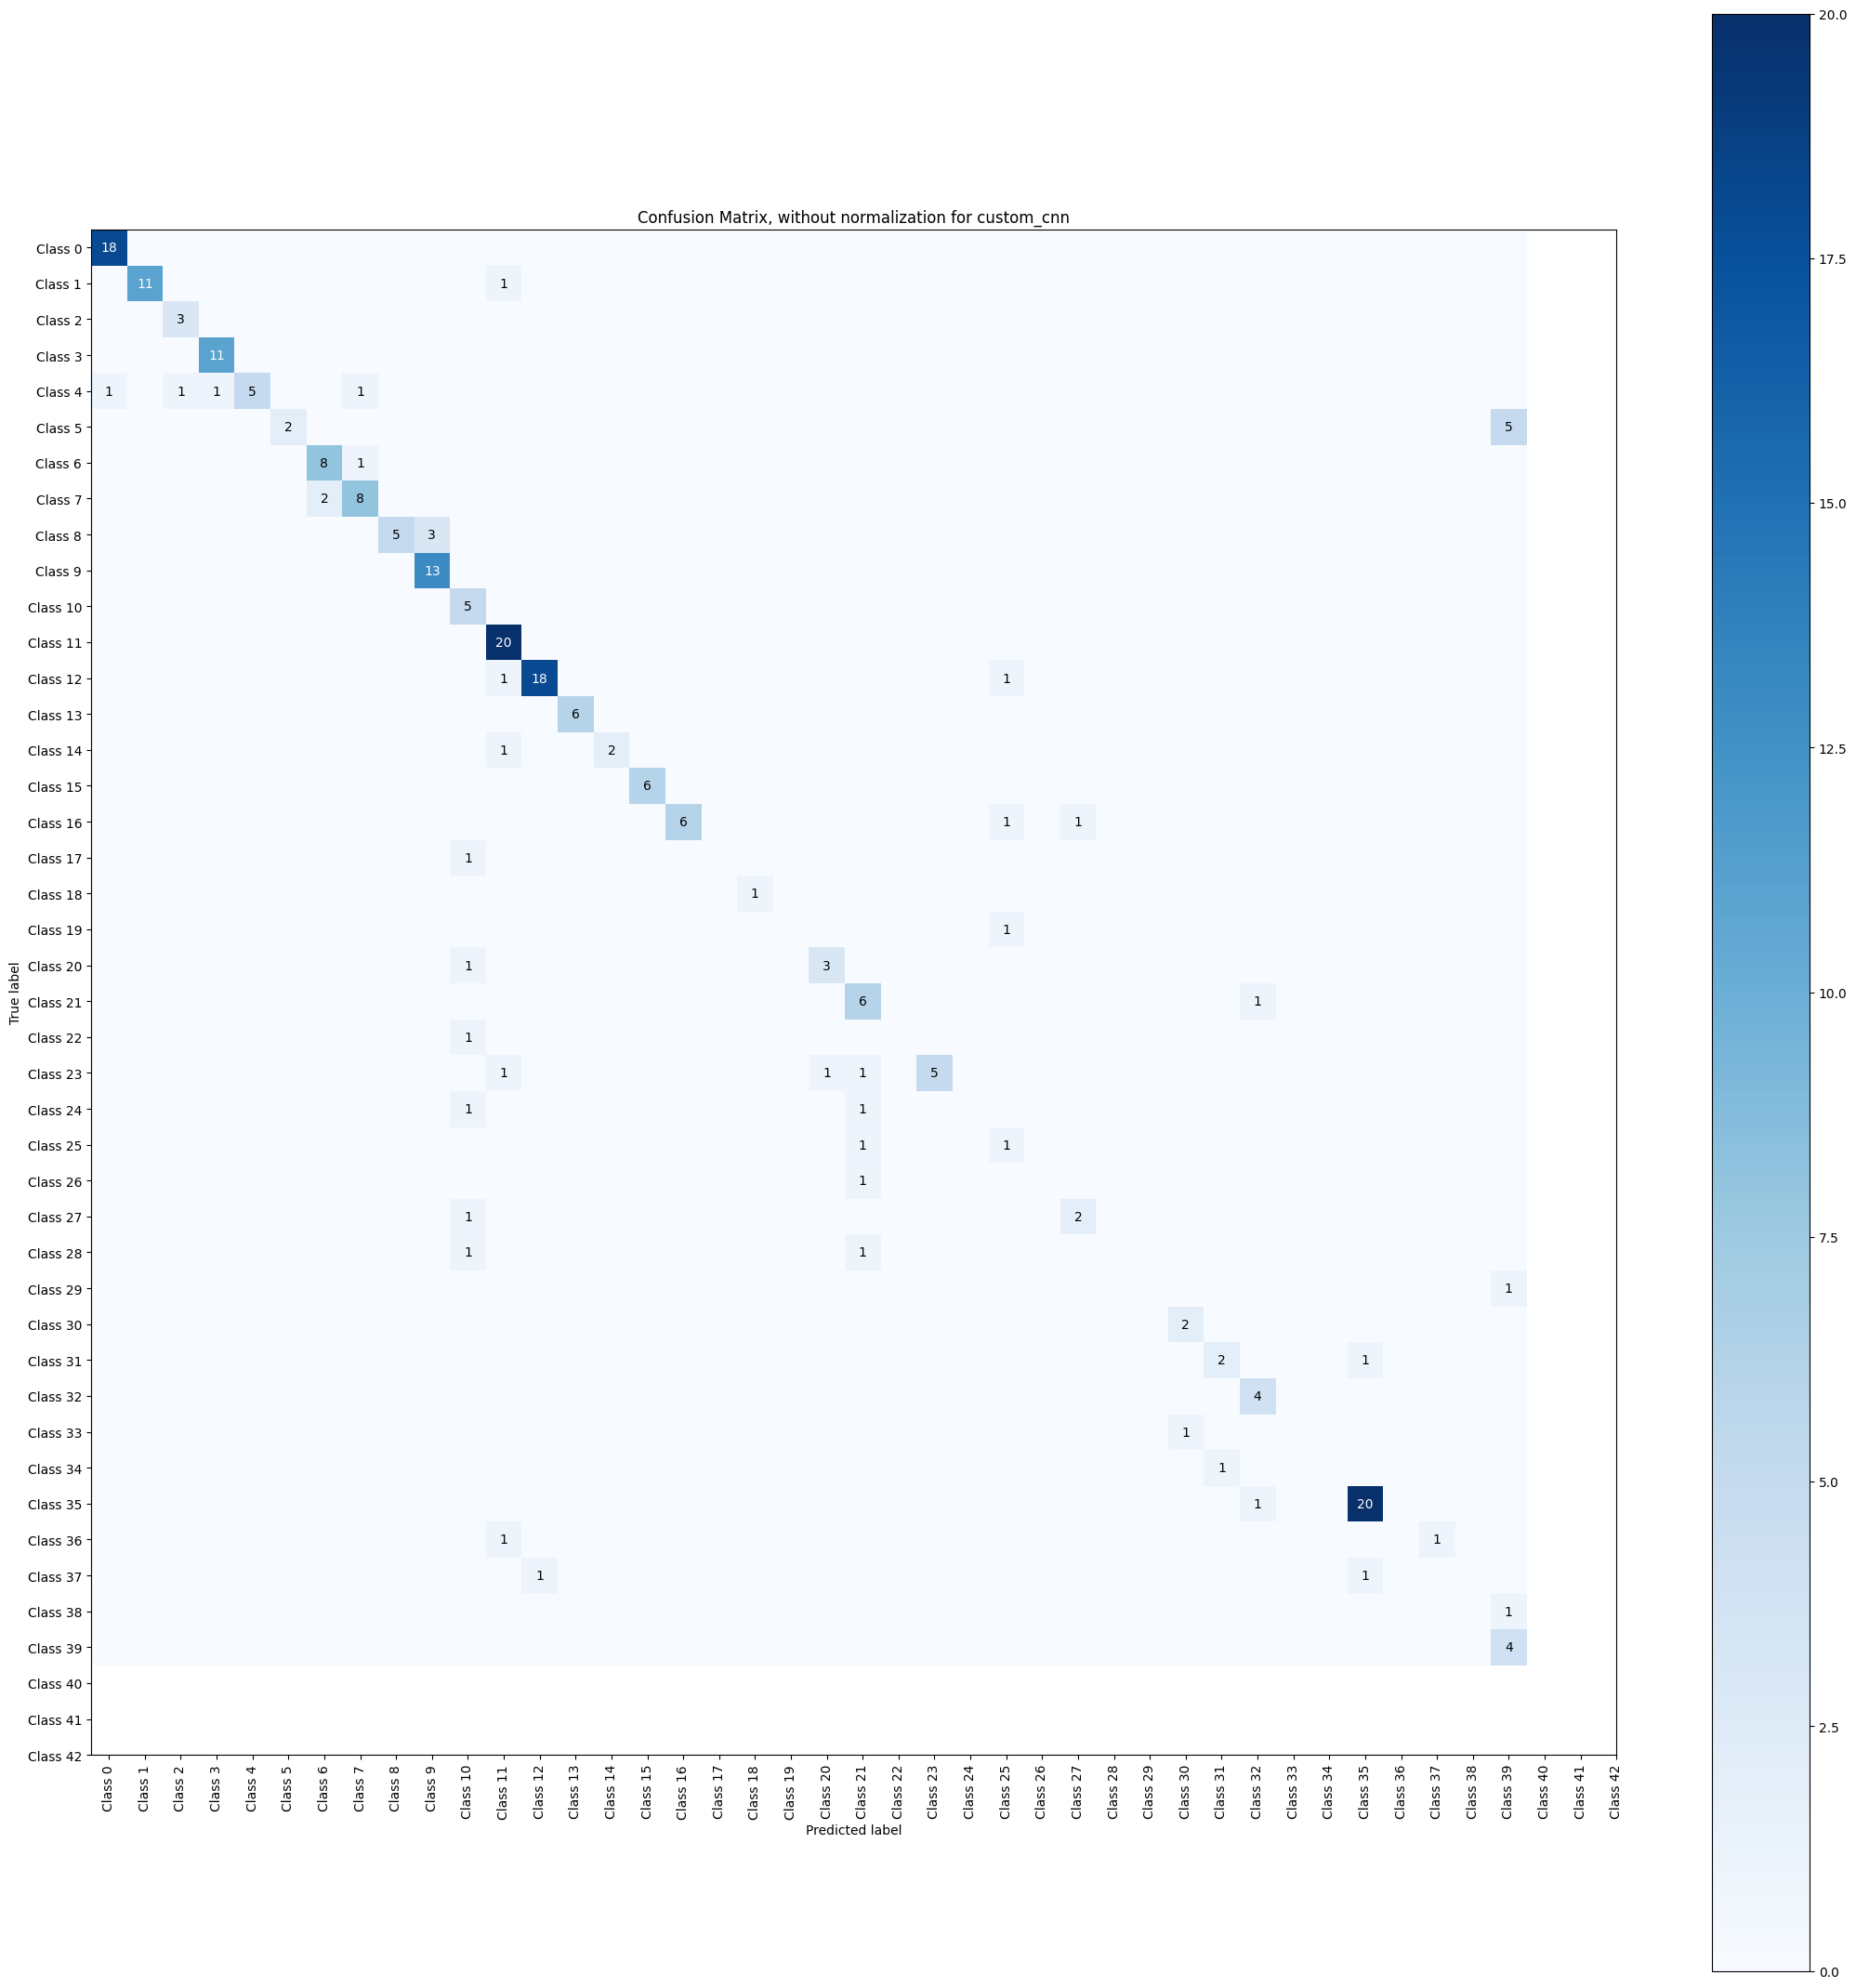

In [ ]:
from sklearn.metrics import classification_report

# Model instantiation for testing
model = CustomCNN(num_classes=43)
weight_key = 'custom_cnn'  # Use the same key as when you saved the model after training

# Invoke the testing function
testing(model, weight_key)


### 10.1 Prediction


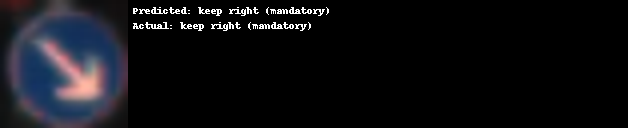

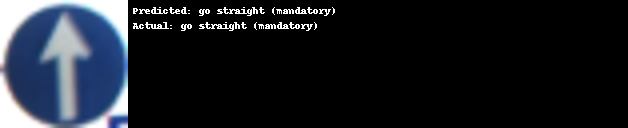

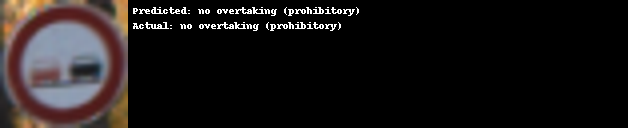

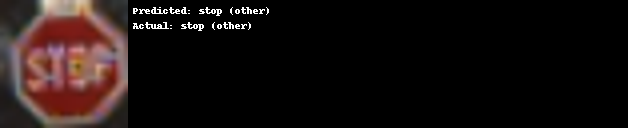

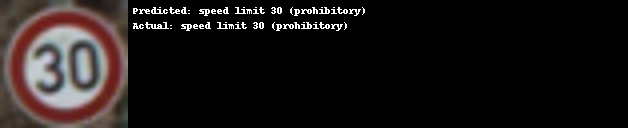

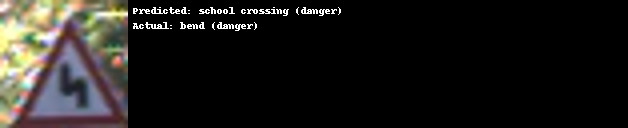

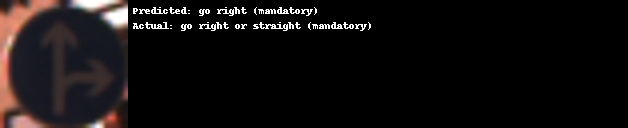

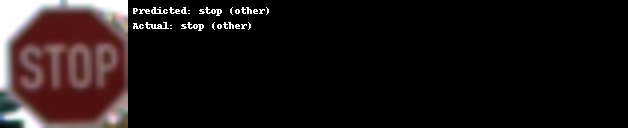

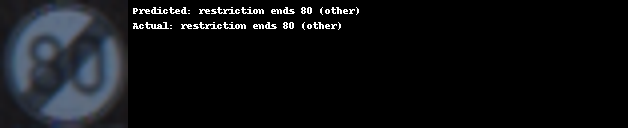

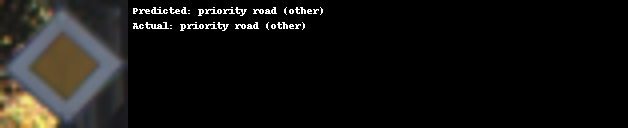

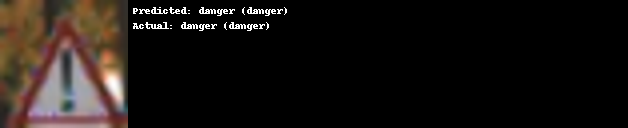

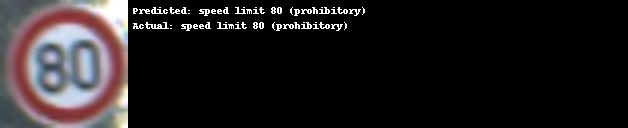

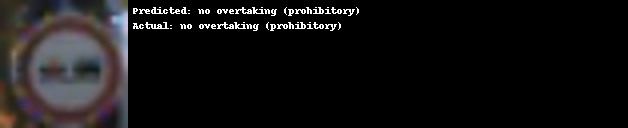

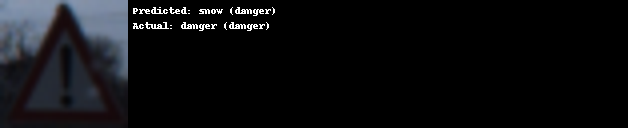

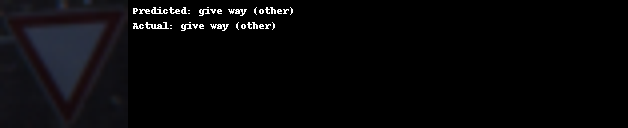

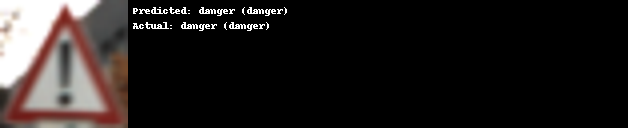

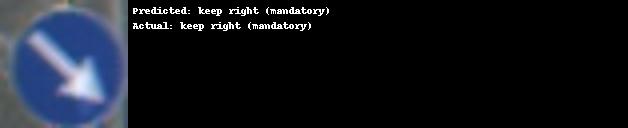

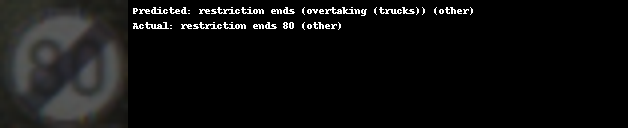

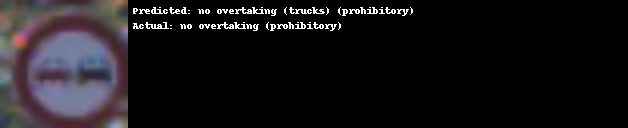

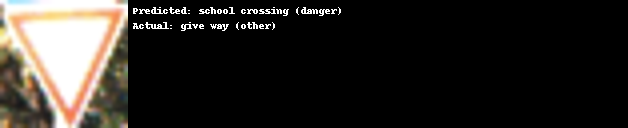

In [ ]:
predict_and_display_individual_test_images_pil_colab(model, weight_key, num_images=20, image_size=128, text_width=500)
